## 1. Dataset Introduction

The Auto MPG dataset is a classic dataset from the UCI Machine Learning Repository that contains information about various automobiles from the late 1970s to early 1980s. It consists of technical and performance specifications for 398 vehicles, including attributes like miles per gallon (mpg), cylinders, engine displacement, horsepower, weight, acceleration, model year, country of origin, and car name. The main objective is to predict the mpg (miles per gallon) based on these features using regression techniques.

### Column Descriptions:
- **mpg** (float): Miles per gallon (target variable)
- **cylinders** (int): Number of cylinders
- **displacement** (float): Engine displacement (cubic inches)
- **horsepower** (float): Engine horsepower (*may have missing values*)
- **weight** (float): Vehicle weight (lbs)
- **acceleration** (float): Time to accelerate from 0 to 60 mph (seconds)
- **model year** (int): Model year (e.g., 70 = 1970)
- **origin** (int): Origin of car (1: USA, 2: Europe, 3: Japan)
- **car name** (string): Car name and model

> 🔹 **Note:** The dataset includes some missing values (especially in "horsepower") marked as '?', so it needs cleaning before modeling.


## 1. Dataset Loading and Preview

Let's load the Auto MPG dataset, specify column names, and display the first few rows to verify the data was imported correctly.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

filename = "../data/auto-mpg.data"
dataframe = pd.read_csv(filename, header=None,sep='\s+',
                         names=["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"],
                         na_values="?", comment="\t", skipinitialspace=True)
print (f"Dataset loaded successfully. {dataframe.shape[0]} rows and {dataframe.shape[1]} columns.")
dataframe.head()


Dataset loaded successfully. 398 rows and 9 columns.


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


### Initial Data Exploration

In this section, we will:
- Check for missing values in each column
- Review the overall structure and data types
- Display basic descriptive statistics for numerical columns

In [88]:
print("Missing values per column:")
print(dataframe.isnull().sum())
print("---")

print("General DataFrame Info:")
dataframe.info()
print("---")

print("Dataset Statistical Overview:")
print(dataframe.describe())
print("---")


Missing values per column:
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64
---
General DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB
---
Dataset Statistical Overview:
              mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.0

#### Feature Analysis

For each feature, we describe its type, value range, distribution, and possible impact on modeling.
Use `describe()`, `unique()`, and `value_counts()` as needed.
Pay attention to:
- Outliers or odd values
- Class imbalance for categorical features
- Missing values
- Data type conversion (integer/categorical)

In [89]:
print("Column types:\n")
print(dataframe.dtypes)
print("\nUnique columns:", dataframe.columns.tolist())

numeric_cols = dataframe.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    print(f"---\nColumn: {col}")
    print("Stats:")
    print(dataframe[col].describe())
    print("Nulls:", dataframe[col].isnull().sum())
    print("Unique values:", dataframe[col].nunique())
    print()

categorical_cols = ['cylinders', 'model_year', 'origin', 'car_name']
for col in categorical_cols:
    print(f"---\nColumn: {col}")
    print("Unique values/count:", dataframe[col].nunique())
    print("Sample values:", dataframe[col].unique()[:10])  
    print("Top 10 most common:")
    print(dataframe[col].value_counts().head(10))
    print()


Column types:

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

Unique columns: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
---
Column: mpg
Stats:
count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64
Nulls: 0
Unique values: 129

---
Column: cylinders
Stats:
count    398.000000
mean       5.454774
std        1.701004
min        3.000000
25%        4.000000
50%        4.000000
75%        8.000000
max        8.000000
Name: cylinders, dtype: float64
Nulls: 0
Unique values: 5

---
Column: displacement
Stats:
count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%    

### Cleaning the "horsepower" feature

In this dataset, only the "horsepower" column contains missing values (represented as "?").  
For simplicity, we remove all rows where horsepower is missing and convert the column to float.  
This ensures the data is ready for further analysis and modeling.

In [90]:
print("Number of missing values in horsepower:", dataframe['horsepower'].isnull().sum())
cleaned_dataframe = dataframe.dropna(subset=['horsepower']).copy()
print("Missing values after cleaning:", cleaned_dataframe['horsepower'].isnull().sum())
cleaned_dataframe.info()
cleaned_dataframe.head()


Number of missing values in horsepower: 6
Missing values after cleaning: 0
<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car_name      392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


### Correlation Analysis

Understanding the correlation between features (and with the target `mpg`) helps us identify which variables are most predictive and whether there are issues like multicollinearity. Here, we use Pearson correlation as a starting point.

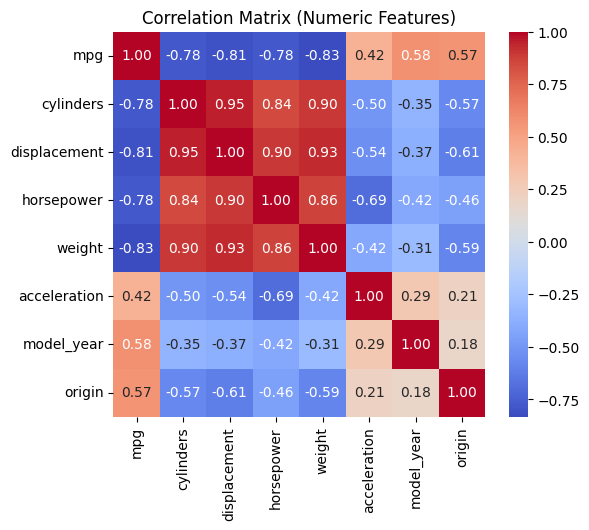

In [91]:
corr_matrix = cleaned_dataframe.corr(numeric_only=True)

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()


#### Scatterplots with Target Variable

Visualizing the relationship between `mpg` and each numeric feature can reveal patterns, linearity, and outliers.

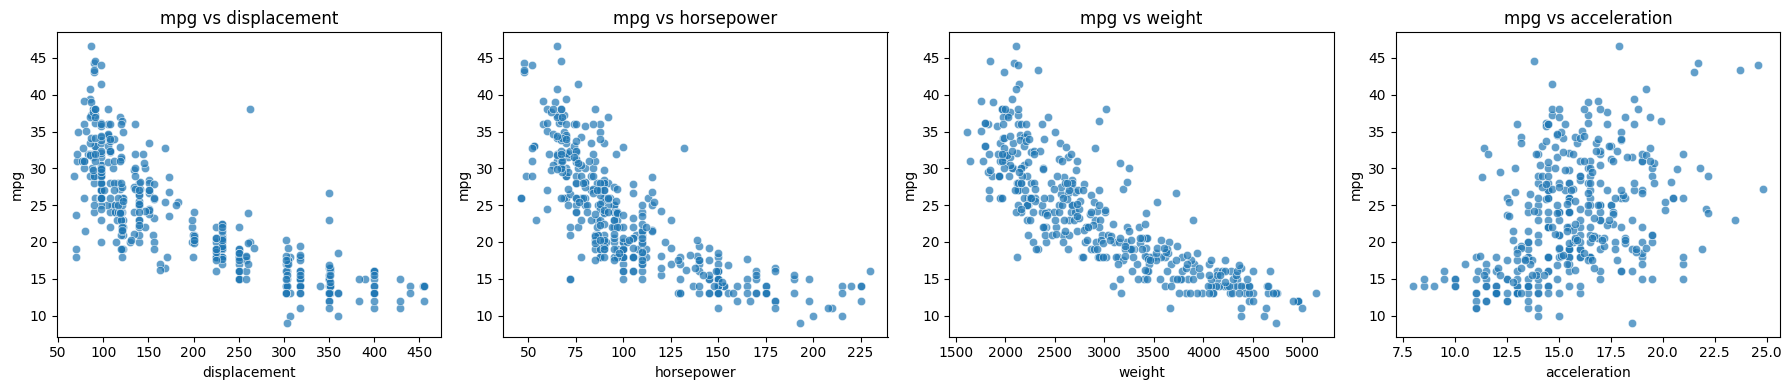

In [92]:
features = ['displacement', 'horsepower', 'weight', 'acceleration']

fig, axs = plt.subplots(1, len(features), figsize=(18,4))
for i, col in enumerate(features):
    sns.scatterplot(data=cleaned_dataframe, x=col, y='mpg', ax=axs[i], alpha=0.7)
    axs[i].set_title(f'mpg vs {col}')
plt.tight_layout()
plt.show()


#### Histograms

Histograms help us understand the distribution, skewness, and potential outliers in numeric features.

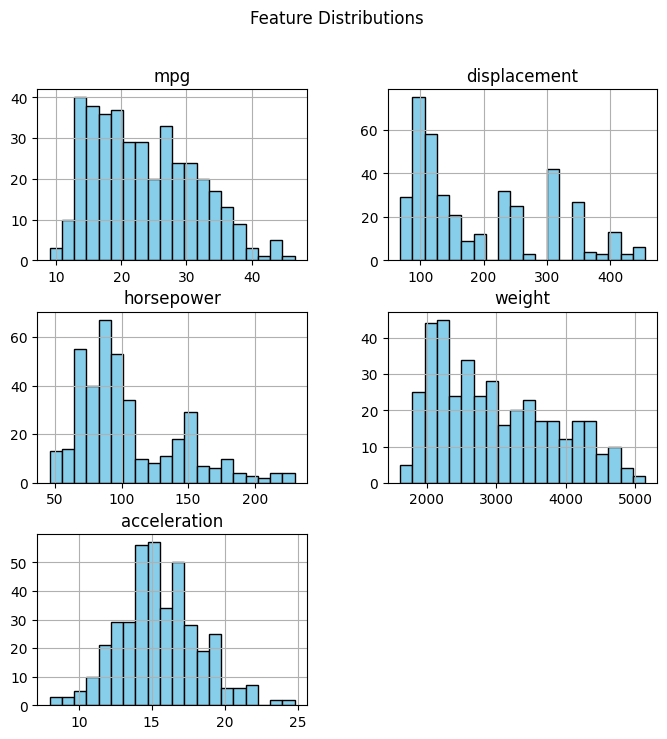

In [93]:
num_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

cleaned_dataframe[num_cols].hist(bins=20, figsize=(8,8), color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions')
plt.show()


### Model Preparation and Training

We use a simple Linear Regression model to predict `mpg` based on the selected features.  
The dataset is split into training and testing sets (80/20).  
After training, we evaluate the model using MAE, RMSE, and R2 score on the test set.


In [94]:
X = cleaned_dataframe[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
y = cleaned_dataframe['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Model coefficients:", model.coef_)
print("Intercept:", model.intercept_)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 score: {r2:.2f}")

Train shape: (313, 7) Test shape: (79, 7)
Model coefficients: [-0.34578883  0.01510871 -0.02130175 -0.00614163  0.03795001  0.76774258
  1.61345707]
Intercept: -18.499361128724747
MAE: 2.42
RMSE: 3.27
R2 score: 0.79


#### Feature Weights (Coefficients) in Linear Regression

The value of each coefficient shows how much the target (`mpg`) is expected to increase or decrease when that feature increases by one unit, holding other features constant.
Positive values: increases `mpg`  
Negative values: decreases `mpg`  
Larger absolute values: stronger effect.

**Note:**  
The size and sign of coefficients can be influenced by the scale of features. It's good practice to standardize features if you want to compare their relative importance directly.

cylinders      : -0.346
displacement   : 0.015
horsepower     : -0.021
weight         : -0.006
acceleration   : 0.038
model_year     : 0.768
origin         : 1.613


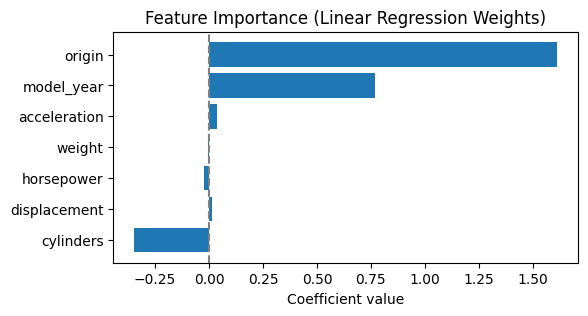

In [95]:
feature_names = X.columns
coefficients = model.coef_

for name, coef in zip(feature_names, coefficients):
    print(f"{name:15}: {coef:.3f}")


plt.figure(figsize=(6,3))
plt.barh(feature_names, coefficients)
plt.xlabel("Coefficient value")
plt.title("Feature Importance (Linear Regression Weights)")
plt.axvline(0, color='gray', linestyle='--')
plt.show()

##### Interpreting the Coefficients

For example, a negative coefficient for "weight" indicates that, holding other factors equal, heavier cars tend to have lower fuel efficiency (`mpg`).  
A positive coefficient for "model_year" means newer cars (higher model_year) tend to have higher `mpg`.

*Note: Absolute coefficient values are only directly comparable when all features are standardized.*


### Standardized Coefficients: Assessing Relative Feature Importance

By standardizing all input features (zero mean, unit variance), the linear regression coefficients become directly comparable across features.  
Now, the magnitude of each coefficient shows the relative importance of that feature in predicting `mpg`.

- **Largest absolute values** correspond to the most influential features.
- The **sign** still indicates the direction of effect (positive: increases mpg, negative: decreases mpg).

**Tip:**  
For practical model interpretation and feature selection, this is a preferred approach.

*Below, we show the standardized coefficients sorted by absolute value for easier comparison.*

        Feature  Coefficient
3        weight    -5.157671
5    model_year     2.782555
1  displacement     1.565273
6        origin     1.300240
2    horsepower    -0.814205
0     cylinders    -0.587055
4  acceleration     0.106767


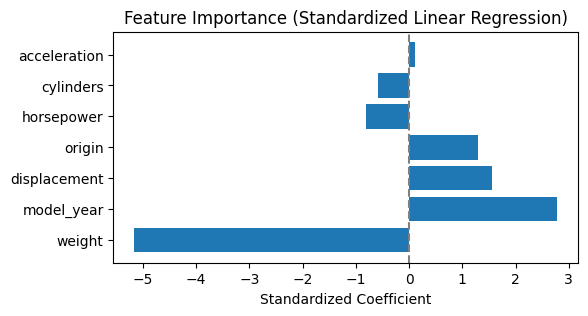

In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)
scaled_coefficients = model_scaled.coef_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': scaled_coefficients
}).sort_values('Coefficient', key=np.abs, ascending=False)

print(feature_importance)

plt.figure(figsize=(6,3))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel("Standardized Coefficient")
plt.title("Feature Importance (Standardized Linear Regression)")
plt.axvline(0, color='gray', linestyle='--')
plt.show()

### Residual Analysis

Analyzing residuals helps us understand the quality of our regression model:

- If residuals are randomly scattered around zero (no pattern), the model's linearity assumption is likely satisfied.
- Significant skewness, patterns, or outliers suggest issues like non-linearity, heteroscedasticity (variance of errors changes), or model misspecification.

**Histogram:** Should be approximately normal for good linear models.  
**Scatter plot of residuals vs predictions:** No clear pattern should be visible. Patterns may indicate the model is missing important relationships.

*In this section, we examine and discuss the distribution and patterns of the residuals for our model.*


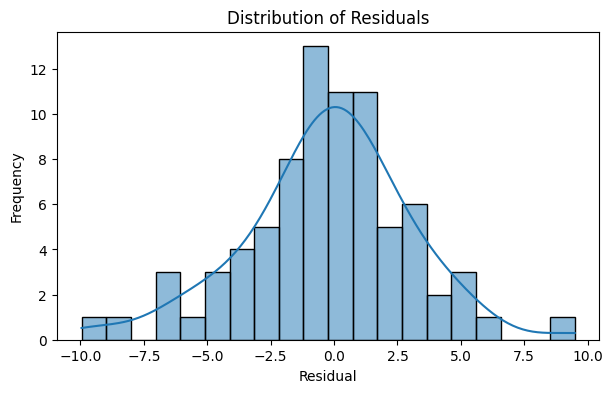

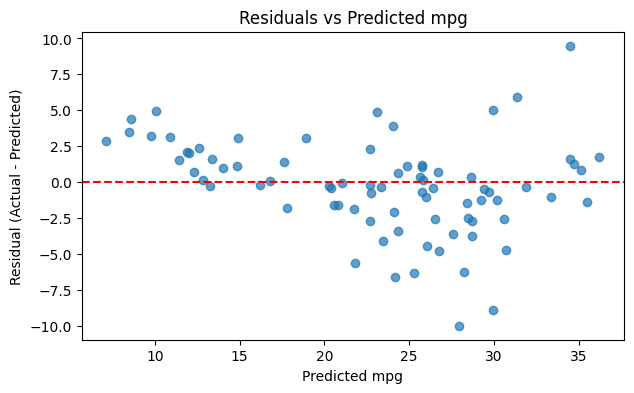

In [97]:
y_pred_scaled = model_scaled.predict(X_test_scaled)
residuals = y_test - y_pred_scaled

plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=20, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(7,4))
plt.scatter(y_pred_scaled, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted mpg')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted mpg')
plt.show()

#### Residuals vs Predicted mpg

This plot checks whether our linear regression model meets the assumption of homoscedasticity (constant variance of residuals) and whether any systematic patterns exist in model errors.

- **Ideal:** Residuals should be randomly scattered around zero, with no clear trend.
- **Your plot:**  
  - Residuals center roughly around zero, but there is some visible pattern:
    - At low predicted mpg (left side), residuals tend to be more positive.
    - At medium-high predicted mpg, residuals are more spread.
    - Some outliers are present, especially for high negative/positive residuals.
  - This suggests slight non-linearity or heteroscedasticity (variance of errors not constant), and possibly a few outlier cars.

**Possible actions:**
- Consider adding polynomial/nonlinear features or using a nonlinear regression model for improvement.
- Investigate outliers for data issues or special cases.


#### Distribution of Residuals

This histogram helps us assess if model errors are approximately normally distributed—a key assumption in linear regression.

- **Ideal:** Symmetric, bell-shaped, centered at zero.
- **Your plot:**  
  - The distribution is *roughly normal*, symmetric and centered near zero.
  - There are a few extreme values (tails), but most residuals fall in the -5 to +5 range.

**Conclusion:**  
The linear model fits reasonably well, but there are several cases with larger errors. The majority of predictions are fairly accurate.


In [98]:
outliers = y_test[np.abs(residuals) > 6]
print("Outlier indices and actual values:\n", outliers)


Outlier indices and actual values:
 210    19.0
394    44.0
389    22.0
270    21.1
111    18.0
366    17.6
Name: mpg, dtype: float64


### Manual Linear Prediction Example

To further understand how linear regression works, let's randomly pick a sample from our test set and calculate its prediction “by hand” using the model's learned coefficients and intercept. The manual result should match sklearn's `.predict()` output.

- $\hat{y} = w_1x_1 + w_2x_2 + ... + w_nx_n + b$
- Below we show the calculation and comparison for one random car.

In [99]:
random_idx = np.random.randint(0, len(X_test)) 
sample_X = X_test.iloc[random_idx]
sample_y = y_test.iloc[random_idx]
sample_X_df = sample_X.to_frame().T 

coefs = model.coef_          
intercept = model.intercept_ 

manual_pred = np.dot(sample_X, coefs) + intercept

model_pred = model.predict(sample_X_df)[0]
print(f"Actual target (mpg): {sample_y:.2f}")
print(f"Manual Prediction:   {manual_pred:.2f}")
print(f"Model Prediction:    {model_pred:.2f}")


Actual target (mpg): 36.00
Manual Prediction:   34.73
Model Prediction:    34.73


### Model Evaluation Visualizations

- **Actual vs Predicted:** Ideally, points should align close to the $y = x$ line. Deviation reveals model bias or variance issues.
- **Metrics on Plot:** R², MAE, RMSE can be shown as text annotations to quickly communicate model quality.

*These plots make evaluation findings intuitive and visually compelling!*


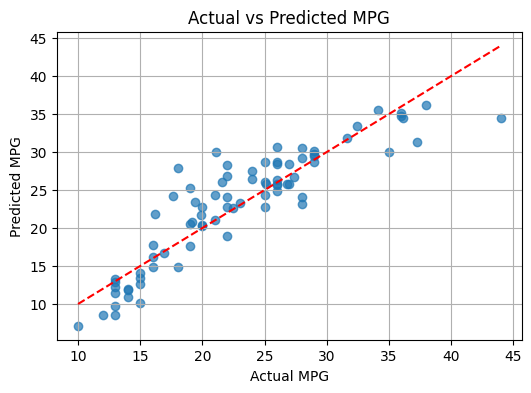

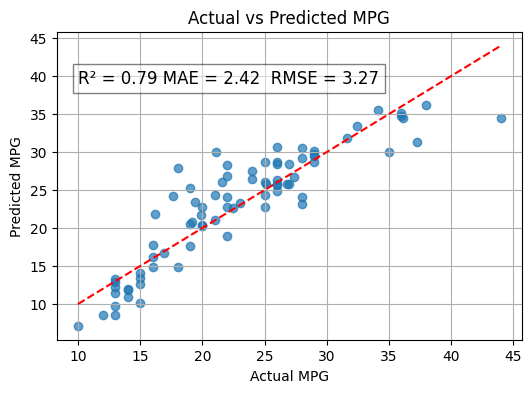

In [100]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Actual vs Predicted MPG')
plt.grid(True)
plt.show()


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Actual vs Predicted MPG')
plt.grid(True)
plt.text(y_test.min(), y_test.max()-5, f'R² = {r2:.2f} MAE = {mae:.2f}  RMSE = {rmse:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()